In [1]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

1.12.0


In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("Demand_History.csv")

In [3]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

In [4]:
import matplotlib.pyplot as plt 

In [5]:
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

In [6]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
d = ChickenpoxDatasetLoader().get_dataset(lags = 4)
next(iter(d))

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])

In [7]:
import json
import urllib
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal


class ChickenpoxDatasetLoader(object):
    """A dataset of county level chicken pox cases in Hungary between 2004
    and 2014. We made it public during the development of PyTorch Geometric
    Temporal. The underlying graph is static - vertices are counties and
    edges are neighbourhoods. Vertex features are lagged weekly counts of the
    chickenpox cases (we included 4 lags). The target is the weekly number of
    cases for the upcoming week (signed integers). Our dataset consist of more
    than 500 snapshots (weeks).
    """

    def __init__(self):
        self._read_web_data()

    def _read_web_data(self):
        url = "https://raw.githubusercontent.com/benedekrozemberczki/pytorch_geometric_temporal/master/dataset/chickenpox.json"
        self._dataset = json.loads(urllib.request.urlopen(url).read())

    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        self._edge_weights = np.ones(self._edges.shape[1])

    def _get_targets_and_features(self):
#         stacked_target = np.array(self._dataset["FX"])
#         self.features = [
#             stacked_target[i : i + self.lags, :].T
#             for i in range(stacked_target.shape[0] - self.lags)
#         ]
#         self.targets = [
#             stacked_target[i + self.lags, :].T
#             for i in range(stacked_target.shape[0] - self.lags)
#         ]
        indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]

        # Generate observations
        features, target = [], []
        for i, j in indices:
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, 0, i + num_timesteps_in : j]).numpy())

        self.features = features
        self.targets = target
    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset

In [8]:
dictn = ChickenpoxDatasetLoader()._dataset

In [9]:
df = pd.read_csv("Demand_History.csv")

In [10]:
edges = []
for a in df['demand_point_index']:
    if(a-64>=0):
        edges.append([a,a-64])
    if(a-1>=0):
        edges.append([a,a-1])
    if(a+1<4096):
        edges.append([a,a+1])
    if(a+64<4096):
        edges.append([a,a+64])


In [11]:
print(edges)

[[0, 1], [0, 64], [1, 0], [1, 2], [1, 65], [2, 1], [2, 3], [2, 66], [3, 2], [3, 4], [3, 67], [4, 3], [4, 5], [4, 68], [5, 4], [5, 6], [5, 69], [6, 5], [6, 7], [6, 70], [7, 6], [7, 8], [7, 71], [8, 7], [8, 9], [8, 72], [9, 8], [9, 10], [9, 73], [10, 9], [10, 11], [10, 74], [11, 10], [11, 12], [11, 75], [12, 11], [12, 13], [12, 76], [13, 12], [13, 14], [13, 77], [14, 13], [14, 15], [14, 78], [15, 14], [15, 16], [15, 79], [16, 15], [16, 17], [16, 80], [17, 16], [17, 18], [17, 81], [18, 17], [18, 19], [18, 82], [19, 18], [19, 20], [19, 83], [20, 19], [20, 21], [20, 84], [21, 20], [21, 22], [21, 85], [22, 21], [22, 23], [22, 86], [23, 22], [23, 24], [23, 87], [24, 23], [24, 25], [24, 88], [25, 24], [25, 26], [25, 89], [26, 25], [26, 27], [26, 90], [27, 26], [27, 28], [27, 91], [28, 27], [28, 29], [28, 92], [29, 28], [29, 30], [29, 93], [30, 29], [30, 31], [30, 94], [31, 30], [31, 32], [31, 95], [32, 31], [32, 33], [32, 96], [33, 32], [33, 34], [33, 97], [34, 33], [34, 35], [34, 98], [35, 34

In [12]:
df.drop(['x_coordinate', 'y_coordinate'], axis=1)

,demand_point_index,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572
1,1,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091
2,2,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254
3,3,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302
4,4,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563
...,...,...,...,...,...,...,...,...,...,...
4091,4091,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193
4092,4092,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450
4093,4093,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519
4094,4094,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574


In [13]:
print(dictn['node_ids'])

{'BACS': 0, 'BARANYA': 1, 'BEKES': 2, 'BORSOD': 3, 'BUDAPEST': 4, 'CSONGRAD': 5, 'FEJER': 6, 'GYOR': 7, 'HAJDU': 8, 'HEVES': 9, 'JASZ': 10, 'KOMAROM': 11, 'NOGRAD': 12, 'PEST': 13, 'SOMOGY': 14, 'SZABOLCS': 15, 'TOLNA': 16, 'VAS': 17, 'VESZPREM': 18, 'ZALA': 19}


In [14]:
node_ids = {}
for i in range(len(df)):
    node_ids[str(df.loc[i,'x_coordinate'])+", "+str(df.loc[i,'y_coordinate'])] = i

In [15]:
print(node_ids)

{'0.5, 0.5': 0, '1.5, 0.5': 1, '2.5, 0.5': 2, '3.5, 0.5': 3, '4.5, 0.5': 4, '5.5, 0.5': 5, '6.5, 0.5': 6, '7.5, 0.5': 7, '8.5, 0.5': 8, '9.5, 0.5': 9, '10.5, 0.5': 10, '11.5, 0.5': 11, '12.5, 0.5': 12, '13.5, 0.5': 13, '14.5, 0.5': 14, '15.5, 0.5': 15, '16.5, 0.5': 16, '17.5, 0.5': 17, '18.5, 0.5': 18, '19.5, 0.5': 19, '20.5, 0.5': 20, '21.5, 0.5': 21, '22.5, 0.5': 22, '23.5, 0.5': 23, '24.5, 0.5': 24, '25.5, 0.5': 25, '26.5, 0.5': 26, '27.5, 0.5': 27, '28.5, 0.5': 28, '29.5, 0.5': 29, '30.5, 0.5': 30, '31.5, 0.5': 31, '32.5, 0.5': 32, '33.5, 0.5': 33, '34.5, 0.5': 34, '35.5, 0.5': 35, '36.5, 0.5': 36, '37.5, 0.5': 37, '38.5, 0.5': 38, '39.5, 0.5': 39, '40.5, 0.5': 40, '41.5, 0.5': 41, '42.5, 0.5': 42, '43.5, 0.5': 43, '44.5, 0.5': 44, '45.5, 0.5': 45, '46.5, 0.5': 46, '47.5, 0.5': 47, '48.5, 0.5': 48, '49.5, 0.5': 49, '50.5, 0.5': 50, '51.5, 0.5': 51, '52.5, 0.5': 52, '53.5, 0.5': 53, '54.5, 0.5': 54, '55.5, 0.5': 55, '56.5, 0.5': 56, '57.5, 0.5': 57, '58.5, 0.5': 58, '59.5, 0.5': 59,

In [16]:
print(dictn["FX"][0])

[-0.0010813572438314102, -0.7111360851371564, -3.2280851520444855, 0.6474982056959225, -0.1730175634529442, 0.3634516331693553, -3.417408199937457, -1.9641124554121572, -2.213263740437807, -0.3314071336304518, -1.8379554163297498, -0.3466855756178827, 1.4219122188829028, -0.7704385412922725, -0.7806110389171145, -1.0993456072643786, 2.4583395074634686, 1.094453096930145, -0.708747750457175, -1.8228079203310248]


In [17]:
FX = []
for j in range(len(df.drop(['x_coordinate', 'y_coordinate','demand_point_index','2018'], axis=1).columns)):
    t = []
    for i in range(len(df)):
        t.append(df.drop(['x_coordinate', 'y_coordinate','demand_point_index','2018'], axis=1).iloc[i,j])
    FX.append(t)

In [18]:
print(FX)

[[0.3522418022689358, 0.3259398810662806, 0.3737523379333782, 0.4206861758559435, 0.475620673308087, 0.3801563609291457, 0.4493481690725345, 0.4700707366344343, 0.5373067041355337, 0.4457343704411967, 0.4509741885119432, 0.4509475094683213, 0.4882452853436773, 0.3999438331239126, 0.4148481271681603, 0.4876637561856138, 0.5229833104731056, 0.4189890246147573, 0.3750797421569914, 0.3390772231069662, 0.316241496331751, 0.395089958013302, 0.3922754750746071, 0.3902617268403657, 0.4176762985343272, 0.3663132046334367, 0.4549098594523717, 0.455642949554137, 0.4549910593898287, 0.5054563815592169, 0.5894597206086774, 0.7219604947253848, 0.7508436293004999, 0.7479671178102063, 1.3255340394971489, 0.8618258272947705, 0.8414963025024333, 0.809080791318455, 0.7739661529222679, 1.1556027785655771, 2.2395771074020248, 2.113545937312144, 1.5163928778005715, 0.843202916635426, 0.5617315074109461, 0.4795746896097715, 0.4534060908694817, 0.6629918881697381, 0.7264400212843865, 0.7264095795004252, 1.596

In [19]:
df_final = {
    "edges" : edges,
    "node_ids" : node_ids,
    "FX" : FX
}

In [20]:
print(df_final)

{'edges': [[0, 1], [0, 64], [1, 0], [1, 2], [1, 65], [2, 1], [2, 3], [2, 66], [3, 2], [3, 4], [3, 67], [4, 3], [4, 5], [4, 68], [5, 4], [5, 6], [5, 69], [6, 5], [6, 7], [6, 70], [7, 6], [7, 8], [7, 71], [8, 7], [8, 9], [8, 72], [9, 8], [9, 10], [9, 73], [10, 9], [10, 11], [10, 74], [11, 10], [11, 12], [11, 75], [12, 11], [12, 13], [12, 76], [13, 12], [13, 14], [13, 77], [14, 13], [14, 15], [14, 78], [15, 14], [15, 16], [15, 79], [16, 15], [16, 17], [16, 80], [17, 16], [17, 18], [17, 81], [18, 17], [18, 19], [18, 82], [19, 18], [19, 20], [19, 83], [20, 19], [20, 21], [20, 84], [21, 20], [21, 22], [21, 85], [22, 21], [22, 23], [22, 86], [23, 22], [23, 24], [23, 87], [24, 23], [24, 25], [24, 88], [25, 24], [25, 26], [25, 89], [26, 25], [26, 27], [26, 90], [27, 26], [27, 28], [27, 91], [28, 27], [28, 29], [28, 92], [29, 28], [29, 30], [29, 93], [30, 29], [30, 31], [30, 94], [31, 30], [31, 32], [31, 95], [32, 31], [32, 33], [32, 96], [33, 32], [33, 34], [33, 97], [34, 33], [34, 35], [34, 98

In [26]:
class ShellAI(object):


    def __init__(self):
        self._dataset = df_final

    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        self._edge_weights = np.ones(self._edges.shape[1])

    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["FX"])
        self.features = [
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]
        self.targets = [
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]

    def get_dataset(self, lags: int = 3) -> StaticGraphTemporalSignal:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset

In [27]:
loader = ShellAI()

In [28]:
data = loader.get_dataset(lags=3)

In [29]:
next(iter(data))

Data(x=[4096, 3], edge_index=[2, 16254], edge_attr=[16254], y=[4096])

In [30]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=1, periods=1)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [31]:
device = torch.device('cuda') # cuda

# Create model and optimizers
model = TemporalGNN(node_features=1, periods=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in range(1000): 
    loss = 0
    step = 0
    for snapshot in data :
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x.reshape(4096,1,3), snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...
Epoch 0 train MSE: 4034.2666
Epoch 1 train MSE: 4011.4976
Epoch 2 train MSE: 3989.3613
Epoch 3 train MSE: 3971.2964
Epoch 4 train MSE: 3957.2192
Epoch 5 train MSE: 3945.0835
Epoch 6 train MSE: 3933.6003
Epoch 7 train MSE: 3922.3867
Epoch 8 train MSE: 3911.2837
Epoch 9 train MSE: 3900.2156
Epoch 10 train MSE: 3889.1226
Epoch 11 train MSE: 3877.7593
Epoch 12 train MSE: 3866.0515
Epoch 13 train MSE: 3853.5093
Epoch 14 train MSE: 3840.8647
Epoch 15 train MSE: 3828.8696
Epoch 16 train MSE: 3817.0957
Epoch 17 train MSE: 3805.4441
Epoch 18 train MSE: 3793.8835
Epoch 19 train MSE: 3782.4058
Epoch 20 train MSE: 3771.0088
Epoch 21 train MSE: 3759.6934
Epoch 22 train MSE: 3748.4617
Epoch 23 train MSE: 3737.3159
Epoch 24 train MSE: 3726.2573
Epoch 25 train MSE: 3715.2866
Epoch 26 train MSE: 3704.4048
Epoch 27 train MSE: 3693.6118
Epoch 28 train MSE: 3682.9070
Epoch 29 train MSE: 3672.2905
Epoch 30 train MSE: 3661.7612
Epoch 31 train MSE: 3651.3179
Epoch 32 train MSE: 3640.9595


Epoch 269 train MSE: 2468.1345
Epoch 270 train MSE: 2466.4304
Epoch 271 train MSE: 2464.7417
Epoch 272 train MSE: 2463.0681
Epoch 273 train MSE: 2461.4102
Epoch 274 train MSE: 2459.7676
Epoch 275 train MSE: 2458.1401
Epoch 276 train MSE: 2456.5273
Epoch 277 train MSE: 2454.9297
Epoch 278 train MSE: 2453.3467
Epoch 279 train MSE: 2451.7783
Epoch 280 train MSE: 2450.2246
Epoch 281 train MSE: 2448.6855
Epoch 282 train MSE: 2447.1606
Epoch 283 train MSE: 2445.6499
Epoch 284 train MSE: 2444.1533
Epoch 285 train MSE: 2442.6709
Epoch 286 train MSE: 2441.2021
Epoch 287 train MSE: 2439.7476
Epoch 288 train MSE: 2438.3064
Epoch 289 train MSE: 2436.8792
Epoch 290 train MSE: 2435.4653
Epoch 291 train MSE: 2434.0649
Epoch 292 train MSE: 2432.6777
Epoch 293 train MSE: 2431.3042
Epoch 294 train MSE: 2429.9434
Epoch 295 train MSE: 2428.5957
Epoch 296 train MSE: 2427.2607
Epoch 297 train MSE: 2425.9387
Epoch 298 train MSE: 2424.6296
Epoch 299 train MSE: 2423.3330
Epoch 300 train MSE: 2422.0488
Epoch 30

Epoch 534 train MSE: 2263.4795
Epoch 535 train MSE: 2263.0771
Epoch 536 train MSE: 2262.6812
Epoch 537 train MSE: 2262.2866
Epoch 538 train MSE: 2261.8945
Epoch 539 train MSE: 2261.5039
Epoch 540 train MSE: 2261.1160
Epoch 541 train MSE: 2260.7300
Epoch 542 train MSE: 2260.3459
Epoch 543 train MSE: 2259.9639
Epoch 544 train MSE: 2259.5840
Epoch 545 train MSE: 2259.2058
Epoch 546 train MSE: 2258.8311
Epoch 547 train MSE: 2258.4583
Epoch 548 train MSE: 2258.0874
Epoch 549 train MSE: 2257.7192
Epoch 550 train MSE: 2257.3521
Epoch 551 train MSE: 2256.9873
Epoch 552 train MSE: 2256.6245
Epoch 553 train MSE: 2256.2637
Epoch 554 train MSE: 2255.9053
Epoch 555 train MSE: 2255.5488
Epoch 556 train MSE: 2255.1941
Epoch 557 train MSE: 2254.8408
Epoch 558 train MSE: 2254.4900
Epoch 559 train MSE: 2254.1436
Epoch 560 train MSE: 2253.7961
Epoch 561 train MSE: 2253.4517
Epoch 562 train MSE: 2253.1099
Epoch 563 train MSE: 2252.7690
Epoch 564 train MSE: 2252.4338
Epoch 565 train MSE: 2252.0955
Epoch 56

Epoch 799 train MSE: 2204.6758
Epoch 800 train MSE: 2204.5828
Epoch 801 train MSE: 2204.4651
Epoch 802 train MSE: 2204.3708
Epoch 803 train MSE: 2204.2537
Epoch 804 train MSE: 2204.1514
Epoch 805 train MSE: 2204.0471
Epoch 806 train MSE: 2203.9436
Epoch 807 train MSE: 2203.8347
Epoch 808 train MSE: 2203.7302
Epoch 809 train MSE: 2203.6230
Epoch 810 train MSE: 2203.5132
Epoch 811 train MSE: 2203.4006
Epoch 812 train MSE: 2203.2852
Epoch 813 train MSE: 2203.1675
Epoch 814 train MSE: 2203.0430
Epoch 815 train MSE: 2202.9165
Epoch 816 train MSE: 2202.7891
Epoch 817 train MSE: 2202.6572
Epoch 818 train MSE: 2202.5203
Epoch 819 train MSE: 2202.3984
Epoch 820 train MSE: 2202.3345
Epoch 821 train MSE: 2202.5415
Epoch 822 train MSE: 2202.2603
Epoch 823 train MSE: 2202.4812
Epoch 824 train MSE: 2202.6211
Epoch 825 train MSE: 2202.7090
Epoch 826 train MSE: 2202.5356
Epoch 827 train MSE: 2202.1023
Epoch 828 train MSE: 2201.8152
Epoch 829 train MSE: 2201.8589
Epoch 830 train MSE: 2201.3335
Epoch 83

In [32]:
T = []
for j in range(len(df.drop(['x_coordinate', 'y_coordinate','demand_point_index','2010','2011','2012','2013','2014'], axis=1).columns)):
    t = []
    for i in range(len(df)):
        t.append(df.drop(['x_coordinate', 'y_coordinate','demand_point_index','2010','2011','2012','2013','2014'], axis=1).iloc[i,j])
    T.append(t)

In [33]:
df_test = {
    "edges" : edges,
    "node_ids" : node_ids,
    "FX" : T
}

In [34]:
class TestData(object):


    def __init__(self):
        self._dataset = df_test

    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        self._edge_weights = np.ones(self._edges.shape[1])

    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["FX"])
        self.features = [
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]
        self.targets = [
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]

    def get_dataset(self, lags: int = 3) -> StaticGraphTemporalSignal:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset

In [35]:
model.eval()

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [36]:
test_dataset = TestData().get_dataset(lags=3)

In [37]:
next(iter(test_dataset))

Data(x=[4096, 3], edge_index=[2, 16254], edge_attr=[16254], y=[4096])

In [38]:
device = torch.device('cuda') # cuda
loss = 0
step = 0

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x.reshape(4096,1,3), snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    print(step)

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

1
Test MSE: 3779.1479


In [45]:
pred = np.array(predictions[0].detach().cpu())

In [49]:
pred = pred.reshape(4096,)

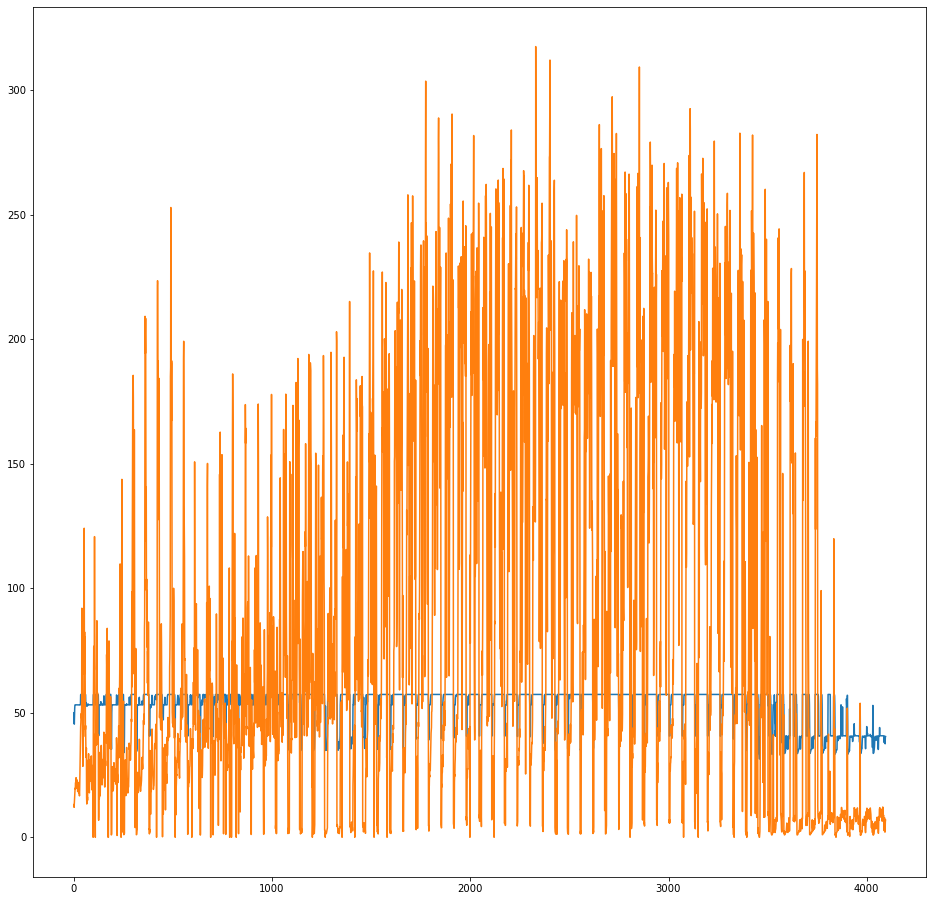

In [51]:
fig = plt.figure(figsize=(16,16))
plt.plot(range(0,4096),pred)
plt.plot(range(0,4096),df.loc[:,'2018'])
# plt.scatter(range(0,32),df.iloc[:32,0])
plt.show()